In [1]:
# # Enable remote debugging
# import debugpy
# import os

# # Only enable debugging if not already enabled
# if not debugpy.is_client_connected():
#     debugpy.listen(("localhost", 5678))
#     print("Waiting for debugger to attach...")
#     debugpy.wait_for_client()
#     print("Debugger attached!")

In [2]:
import networkx as nx
import nx_arangodb as nxadb

from arango import ArangoClient

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from random import randint
import re

from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI
from langchain_community.graphs import ArangoGraph
from langchain_community.chains.graph_qa.arangodb import ArangoGraphQAChain
from langchain_core.tools import tool


import gradio as gr
from graph_utils import create_d3_visualization
from dotenv import load_dotenv
import os
from agent_utils import GraphAgent



[22:02:44 -0600] [INFO]: NetworkX-cuGraph is unavailable: No module named 'nx_cugraph'.


In [3]:
load_dotenv()

True

In [4]:
# Access variables
openai_key = os.getenv('OPENAI_API_KEY')
arango_host = os.getenv('ARANGO_HOST')
arango_user = os.getenv('ARANGO_USER')
arango_password = os.getenv('ARANGO_PASSWORD')
arango_db = os.getenv('ARANGO_DB')


In [5]:
# Initialize the client for ArangoDB.
client = ArangoClient(hosts=arango_host)
db = client.db(arango_db, username=arango_user, password=arango_password)
print(db.collections())

[{'id': '195136', 'name': '_analyzers', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '195138', 'name': '_queues', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '195137', 'name': '_aqlfunctions', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '211044', 'name': 'Users', 'system': False, 'type': 'document', 'status': 'loaded'}, {'id': '195139', 'name': '_jobs', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '211045', 'name': 'Games', 'system': False, 'type': 'document', 'status': 'loaded'}, {'id': '195141', 'name': '_appbundles', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '195135', 'name': '_graphs', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '195140', 'name': '_apps', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '211046', 'name': 'plays', 'system': False, 'type': 'edge', 'status': 'loaded'}, {'id': '195142', 'name': '_frontend', 'system': True, 'type': 'docu

In [6]:

G_adb = nxadb.Graph(name="SteamGraph", db=db)

print(G_adb)

[22:02:48 -0600] [INFO]: Graph 'SteamGraph' exists.
[22:02:48 -0600] [INFO]: Default node type set to 'Games'


Graph named 'SteamGraph' with 14950 nodes and 70477 edges


In [7]:
graph_def = db.collection("_graphs").get("SteamGraph")
print(graph_def)


{'_key': 'SteamGraph', '_id': '_graphs/SteamGraph', '_rev': '_jQYqFqO---', 'edgeDefinitions': [{'collection': 'plays', 'from': ['Users'], 'to': ['Games']}], 'orphanCollections': [], 'networkx': {'name': 'SteamGraph'}}


In [8]:
for node, data in list(G_adb.nodes(data=True))[:10]:
    print(node, data.get("_id"))


Users/255473549 Users/255473549
Users/99157622 Users/99157622
Users/89270735 Users/89270735
Users/60115727 Users/60115727
Users/195436818 Users/195436818
Users/141918894 Users/141918894
Users/84883272 Users/84883272
Games/13702_star_traders_4x_empires Games/13702_star_traders_4x_empires
Users/140493636 Users/140493636
Users/12423315 Users/12423315


In [9]:
print(G_adb)

Graph named 'SteamGraph' with 14950 nodes and 70477 edges


### AQL Test

In [10]:
# First, let's check what collections exist
print("Available collections:")
for collection in db.collections():
    print(collection['name'])

# Get the graph to see its collections
graph = db.graph('SteamGraph')
print("\nGraph collections:")
print(graph.edge_definitions())

Available collections:
_analyzers
_queues
_aqlfunctions
Users
_jobs
Games
_appbundles
_graphs
_apps
plays
_frontend

Graph collections:
[{'edge_collection': 'plays', 'from_vertex_collections': ['Users'], 'to_vertex_collections': ['Games']}]


In [11]:


# -----------------------------------------------------------
# 1. Query 3 random nodes from the Users collection.
# -----------------------------------------------------------
result_cursor = G_adb.query("""
    FOR node IN Users
        SORT RAND()
        LIMIT 3
        RETURN node
""")
print("Sample Users Nodes:")
for node in result_cursor:
    print(node)
print('-'*10)

# -----------------------------------------------------------
# 2. Query 3 random edges from the plays edge collection.
# -----------------------------------------------------------
result_cursor = G_adb.query("""
    FOR edge IN plays
        SORT RAND()
        LIMIT 3
        RETURN edge
""")
print("Sample Plays Edges:")
for edge in result_cursor:
    print(edge)
print('-'*10)


Sample Users Nodes:
{'_key': '301656813', '_id': 'Users/301656813', '_rev': '_jPaYbq---w', 'type': 'Users', 'steamid': 301656813}
{'_key': '96232797', '_id': 'Users/96232797', '_rev': '_jPaYbk---4', 'type': 'Users', 'steamid': 96232797}
{'_key': '39869522', '_id': 'Users/39869522', '_rev': '_jPaYbqy-_L', 'type': 'Users', 'steamid': 39869522}
----------
Sample Plays Edges:
{'_key': '12196', '_id': 'plays/12196', '_from': 'Users/93669877', '_to': 'Games/11350_the_elder_scrolls_v_skyrim', '_rev': '_jPaYfku--_', 'weight': 12.1}
{'_key': '48920', '_id': 'plays/48920', '_from': 'Users/101596530', '_to': 'Games/12083_the_escapists', '_rev': '_jPaYhuC--C', 'weight': 13.9}
{'_key': '17856', '_id': 'plays/17856', '_from': 'Users/159000186', '_to': 'Games/11486_dirt_showdown', '_rev': '_jPaYgPm--c', 'weight': 11.1}
----------


### Agent

In [12]:
arango_graph = ArangoGraph(db)


/home/manoj99/miniconda3/envs/Arrongo/lib/python3.10/site-packages/pydantic/_internal/_generate_schema.py:502: UserWarning: <built-in function any> is not a Python type (it may be an instance of an object), Pydantic will allow any object with no validation since we cannot even enforce that the input is an instance of the given type. To get rid of this error wrap the type with `pydantic.SkipValidation`.
  warn(


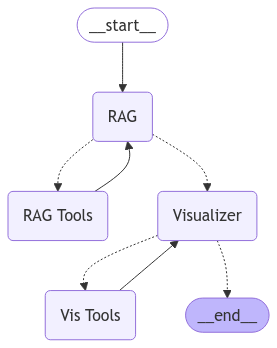

In [13]:
agent = GraphAgent(arango_graph, G_adb)


In [14]:
def create_gradio_interface(agent):
    def display_response(input_text):
        result = agent.query_graph(input_text)  # Assuming this is your existing processing function
        print("Inside interface")
        print(result["html_code"])
        return (
            result["html_code"],  # Already in correct iframe format
            result["reply"]
        )
    
    with gr.Blocks() as interface:
        gr.Markdown("# Graph Analysis Interface")
        
        input_text = gr.Textbox(
            label="Query",
            placeholder="Enter your graph query here...",
            lines=2
        )
        
        with gr.Row():
            submit_btn = gr.Button("Analyze")
        
        # Output containers
        with gr.Row():
            # Use gr.HTML for the iframe content
            html_output = gr.HTML(
                label="Visualization",
                value=""  # Initial empty value
            )
        with gr.Row():
            text_output = gr.Textbox(
                label="Analysis Result", 
                lines=3
            )
            
        submit_btn.click(
            fn=display_response,
            inputs=[input_text],
            outputs=[html_output, text_output]
        )
    
    return interface

In [15]:
interface = create_gradio_interface(agent)
interface.launch()

* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.



Processing Agent State:
{ 'data': [],
  'iframe_html': '',
  'messages': [ HumanMessage(content='Users who have played the most influential game', additional_kwargs={}, response_metadata={}, id='3ec440e9-5f02-4865-a88f-e2c8989932a6')],
  'user_query': 'Users who have played the most influential game'}
Netwrokx Query received:
Find the most influential game based on centrality metrics and show which users play it
----------
1) Generating NetworkX code
----------
import networkx as nx

# Calculate eigenvector centrality for games
game_nodes = [n for n,d in G_adb.nodes(data=True) if d.get('type')=='Games']
game_subgraph = G_adb.subgraph(game_nodes)
centrality = nx.eigenvector_centrality(G_adb)

# Find game with highest centrality
most_central_game = max(game_nodes, key=lambda x: centrality[x])
most_central_game_data = G_adb.nodes[most_central_game]

# Get all users that play this game
user_neighbors = [n for n in G_adb.neighbors(most_central_game) if G_adb.nodes[n].get('type')=='Users']


In [17]:
response = agent.query_graph("Total number of games in the graph")


Processing Agent State:
{ 'data': [],
  'iframe_html': '',
  'messages': [ HumanMessage(content='Total number of games in the graph', additional_kwargs={}, response_metadata={}, id='584de1f6-f633-4f57-bf32-3ec1d2d57c3e')],
  'user_query': 'Total number of games in the graph'}


> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH Games
FOR game IN Games
COLLECT WITH COUNT INTO length
RETURN length

AQL Result:
[3600]

> Finished chain.
print AQL tool result
{'query': 'FOR game IN Games COLLECT WITH COUNT INTO length RETURN length', 'result': 'The total number of games in the database is 3,600.', 'aql_query': '\nWITH Games\nFOR game IN Games\nCOLLECT WITH COUNT INTO length\nRETURN length\n', 'aql_result': [3600]}

Processing Agent State:
{ 'data': [ { 'aql_result': [3600],
              'description': 'The total number of games in the database is '
                             '3,600.'}],
  'iframe_html': '',
  'messages': [ HumanMessage(content='Total number of games in the 

In [14]:
agent.query_graph("Users who have played the most influential game")


Processing Agent State:
{ 'data': [],
  'messages': [ HumanMessage(content='Users who have played the most influential game', additional_kwargs={}, response_metadata={}, id='76b887bb-0451-4af5-b2a3-c0a4803e6726')],
  'user_query': 'Users who have played the most influential game'}
Netwrokx Query received:
Calculate degree centrality for Games and find the game with the highest centrality.
----------
1) Generating NetworkX code
----------
import networkx as nx

# Assuming G_adb is already defined and is a NetworkX graph object

# Calculate degree centrality for Games
# Degree centrality for a node v is the fraction of nodes it is connected to.
# Since we are interested in Games, we need to filter nodes of type 'Games'

# Extract all game nodes
game_nodes = [n for n, attr in G_adb.nodes(data=True) if attr.get('type') == 'Games']

# Calculate degree centrality for all nodes
degree_centrality = nx.degree_centrality(G_adb)

# Filter degree centrality to only include game nodes
game_degree_

[00:56:09 -0600] [INFO]: Graph 'SteamGraph' load took 2.3767833709716797s


EXEC ERROR: name 'degree_centrality' is not defined

Processing Agent State:
{ 'data': [],
  'messages': [ HumanMessage(content='Users who have played the most influential game', additional_kwargs={}, response_metadata={}, id='76b887bb-0451-4af5-b2a3-c0a4803e6726'),
                AIMessage(content='To determine the users who have played the most influential game, we need to follow these steps:\n\n1. **Identify the Most Influential Game**: We need to determine which game is the most influential. This could be interpreted as the game with the highest number of players or the game with the highest total playtime. We will use the `NX_QueryWrapper` to analyze the graph and find the game with the highest centrality or degree.\n\n2. **Find Users Who Played This Game**: Once we have identified the most influential game, we will query the graph to find all users who have played this game using the `AQL_QueryWrapper`.\n\nLet\'s execute these steps. \n\n### Step 1: Identify the Most Influential

'Visulaization Done'

In [14]:
agent.query_graph("Find 2nd and 4th Most influential game in the graph and its number of users who played both of them")


Processing Agent State:
{ 'data': [],
  'messages': [ HumanMessage(content='Find 2nd and 4th Most influential game in the graph and its number of users who played both of them', additional_kwargs={}, response_metadata={}, id='800e2839-3631-462e-940b-74ec1e2c2b3c')],
  'user_query': 'Find 2nd and 4th Most influential game in the graph and its '
                'number of users who played both of them'}

Processing Agent State:
{ 'data': [],
  'messages': [ HumanMessage(content='Find 2nd and 4th Most influential game in the graph and its number of users who played both of them', additional_kwargs={}, response_metadata={}, id='800e2839-3631-462e-940b-74ec1e2c2b3c'),
                AIMessage(content="To address the query, we need to follow these steps:\n\n1. **Identify the Most Influential Games**: Use centrality measures to determine the influence of games in the graph. We will use NetworkX to calculate the centrality of each game and identify the 2nd and 4th most influential games.\n\n

'Visulaization Done'

In [ ]:
agent.query_graph("Find the  top 10 users who played a lot  and which games they have played is common most by hours")


Processing Agent State:
{ 'messages': [ HumanMessage(content='Find the  top 10 users who played a lot  and which games they have played is common most by hours', additional_kwargs={}, response_metadata={}, id='f215f92d-4d51-4083-a4f8-0ea346a4fac7')],
  'user_query': 'Find the  top 10 users who played a lot  and which games they '
                'have played is common most by hours'}


> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH Users, Games, plays
FOR user IN Users
    LET total_hours = SUM(
        FOR play IN plays
            FILTER play._from == user._id
            RETURN play.weight
    )
    SORT total_hours DESC
    LIMIT 10
    RETURN { user_id: user._key, total_hours: total_hours }

AQL Result:
[{'user_id': '73017395', 'total_hours': 11754}, {'user_id': '10599862', 'total_hours': 11651.699999999999}, {'user_id': '100630947', 'total_hours': 10853.2}, {'user_id': '26762388', 'total_hours': 10470.100000000004}, {'user_id': '153382649', 'total_hours': 9640}, 

"Here are the top games most commonly played by the top 10 users based on total hours:\n\n1. **Sid Meier's Civilization V**: 13,197 hours\n2. **Dota 2**: 10,790.4 hours\n3. **Team Fortress 2**: 9,724.7 hours\n4. **Counter-Strike: Global Offensive**: 5,434.6 hours\n5. **Mount & Blade: Warband**: 4,962 hours\n\nThese games are the most popular among the top 10 users with the highest playtime, indicating their gaming preferences."